<a href="https://colab.research.google.com/github/AkithaPasandul/Product-Recommendation-Engine/blob/main/Product_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Data Loading

In [11]:
df = pd.read_csv("/content/1429_1.csv", engine='python')

In [12]:
df.head()

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [14]:
df.shape

(34660, 21)

column selection and rename

In [15]:
df = df[[
    "reviews.username",
    "asins",
    "reviews.rating",
    "reviews.text",
    "reviews.date",
    "categories",
    "brand"
]]

df.rename(columns={
    "reviews.username": "user_id",
    "asins": "product_id",
    "reviews.rating": "rating",
    "reviews.text": "review_text",
    "reviews.date": "review_date"
}, inplace=True)

df.head()

,user_id,product_id,rating,review_text,review_date,categories,brand
0,Adapter,B01AHB9CN2,5.0,This product so far has not disappointed. My c...,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
1,truman,B01AHB9CN2,5.0,great for beginner or experienced person. Boug...,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
2,DaveZ,B01AHB9CN2,5.0,Inexpensive tablet for him to use and learn on...,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
3,Shacks,B01AHB9CN2,4.0,I've had my Fire HD 8 two weeks now and I love...,2017-01-13T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon
4,explore42,B01AHB9CN2,5.0,I bought this for my grand daughter when she c...,2017-01-12T00:00:00.000Z,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      34653 non-null  object 
 1   product_id   34658 non-null  object 
 2   rating       34627 non-null  float64
 3   review_text  34659 non-null  object 
 4   review_date  34621 non-null  object 
 5   categories   34660 non-null  object 
 6   brand        34660 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.9+ MB


In [19]:
df.describe(include="all")

,user_id,product_id,rating,review_text,review_date,categories,brand
count,34653,34658,34627.000000,34659,34621,34660,34660
unique,26788,41,NaN,34659,1078,41,6
top,Mike,B018Y229OU,NaN,to spite the fact that i have nothing but good...,2017-01-16T00:00:00.000Z,"Fire Tablets,Tablets,Computers & Tablets,All T...",Amazon
freq,138,10966,NaN,1,710,10966,28701
mean,NaN,NaN,4.584573,NaN,NaN,NaN,NaN
std,NaN,NaN,0.735653,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


# Data prepocessing

Missing values

In [20]:
(df.isnull().mean() * 100).sort_values(ascending=False)

,0
review_date,0.112522
rating,0.095211
user_id,0.020196
product_id,0.005770
review_text,0.002885
categories,0.000000
brand,0.000000


In [21]:
df.dropna(subset=["user_id", "product_id", "rating"], inplace=True)

Duplicates

In [23]:
duplicates = df.duplicated(subset=["user_id", "product_id"]).sum()
print("Duplicate user-product reviews:", duplicates)

Duplicate user-product reviews: 4010


In [24]:
df.drop_duplicates(subset=["user_id", "product_id"], inplace=True)

Rating validation

In [26]:
df = df[df["rating"].between(1, 5)]

In [27]:
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")
df["year"] = df["review_date"].dt.year

In [28]:
df.head()

,user_id,product_id,rating,review_text,review_date,categories,brand,year
0,Adapter,B01AHB9CN2,5.0,This product so far has not disappointed. My c...,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017.0
1,truman,B01AHB9CN2,5.0,great for beginner or experienced person. Boug...,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017.0
2,DaveZ,B01AHB9CN2,5.0,Inexpensive tablet for him to use and learn on...,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017.0
3,Shacks,B01AHB9CN2,4.0,I've had my Fire HD 8 two weeks now and I love...,2017-01-13 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017.0
4,explore42,B01AHB9CN2,5.0,I bought this for my grand daughter when she c...,2017-01-12 00:00:00+00:00,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Amazon,2017.0


# EDA

Dataset statistics

In [29]:
n_users = df["user_id"].nunique()
n_products = df["product_id"].nunique()
n_reviews = len(df)

In [30]:
print(f"Users: {n_users}")
print(f"Products: {n_products}")
print(f"Reviews: {n_reviews}")

Users: 26763
Products: 38
Reviews: 30608


In [31]:
sparsity = 1 - (n_reviews / (n_users * n_products))
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.9699


## Rating Analysis

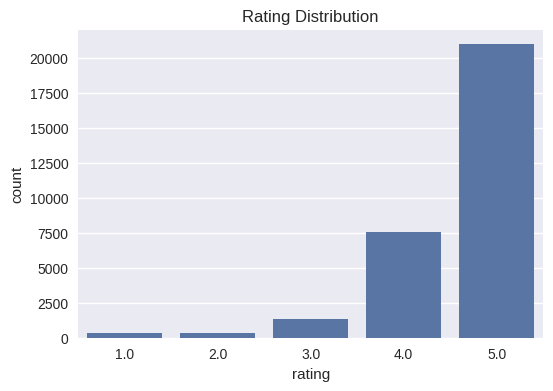

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=df)
plt.title("Rating Distribution")
plt.show()

In [33]:
df["rating"].value_counts(normalize=True).sort_index()

,proportion
rating,
1.0,0.012186
2.0,0.011762
3.0,0.043877
4.0,0.246275
5.0,0.685899


## User behavior analysis

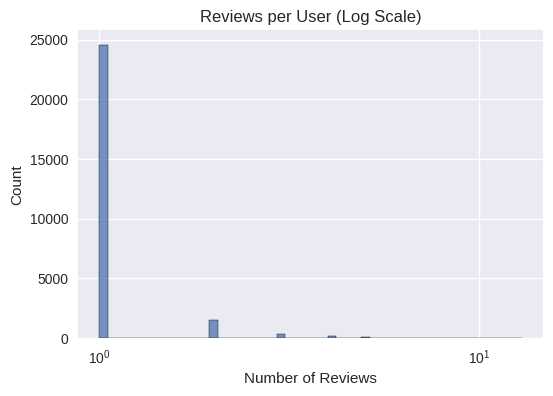

In [34]:
user_review_counts = df["user_id"].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(user_review_counts, bins=50, log_scale=True)
plt.title("Reviews per User (Log Scale)")
plt.xlabel("Number of Reviews")
plt.show()

Most active users

In [35]:
user_review_counts.head(10)

,count
user_id,
Mike,13
Chris,13
Rick,12
John,12
Dave,12
Bill,11
Mark,11
Kris,10
Bobby,10


## Product Analysis

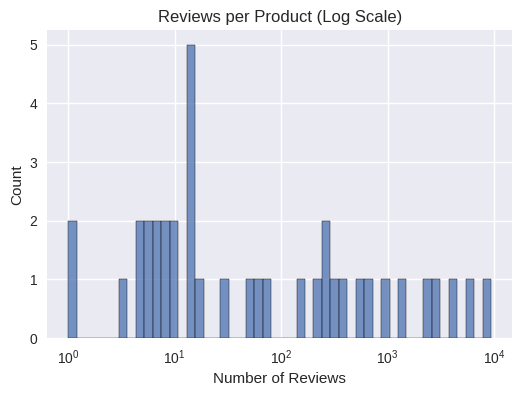

In [36]:
product_review_counts = df["product_id"].value_counts()

plt.figure(figsize=(6,4))
sns.histplot(product_review_counts, bins=50, log_scale=True)
plt.title("Reviews per Product (Log Scale)")
plt.xlabel("Number of Reviews")
plt.show()

In [37]:
product_review_counts.head(10)

,count
product_id,
B018Y229OU,9381
"B00L9EPT8O,B01E6AO69U",5671
B00U3FPN4U,4490
B00OQVZDJM,2878
B01AHB9CN2,2603
B018Y23MNM,1502
B018Y225IA,971
B01BH83OOM,613
B00IOY8XWQ,558
